# Working with the StackExchange data
During the workshop we will be working with a part of the data dump from the StackExchange network.

An (almost) complete description of the data can be found [online here](https://ia801500.us.archive.org/8/items/stackexchange/readme.txt).

# Parquet files, not XML
The data is a direct dump from a relation database, written as XML files. However, XML parsing is tedious and slow, so we have already converted the XML files into the much more useful Parquet format. Parquet files are ar common format on Hadoop and allow for the same type of hierarchical data as XML or JSON, but store the data in binary in a columnar fashion, which is optimized for parallelized access and compression.

Working with Parquet files in Spark is relatively straightforward. Some examples follow.

## Spark SQL
Reading Parquet files is part of the Spark SQL interface. Without going into much detail, we'll just for now suffise with the fact that you need a `SQLContext`, which can be imported and subsequently created from the SparkContext.

In [1]:
from pyspark.sql import SQLContext

In [2]:
sql = SQLContext(sc)

## Opening Parquet files
Parquet files (like most 'files' on Hadoop), actually consist of multiple parts in a directory. Due to a bug in Spark, it is currently not possible to pass a glob expression (e.g. `/some_dir/*.parquet`) to the API, hence we need to specify all of the different parts individually. Here's a snippet that lists the files.

In [11]:
num_parts = 2
basename = '/stackexchange/travel.stackexchange.com/posts'
files = ['%s/part-r-%05d.parquet' % (basename, part) for part in range(1, num_parts + 1)]

# Spark data frames
Spark has a data frame feature, quite similar to the Pandas data frames, but then distributed across the cluster. We won't go into much detail now, but it's worth looking into this later. The Spark SQL context however, will create a data frame from the Parquet files and not directly and RDD.

In [13]:
spark_dataframe = sql.parquetFile(*files)

## Going RDD
Next, we can obtain an RDD from the data frame by property access to the underlying RDD (note that this is not a method, there's no parenthese after `rdd`).

In [14]:
rdd = spark_dataframe.rdd

## Rows and columns
An RDD obtained from a data frame, will consist of Row objects. These are containers for the records in the Parquet files. Let's take one row and have a look what we can do with it.

In [5]:
single_row, = rdd.take(1)

In [6]:
single_row

Row(id=1, postType=1, parent=None, acceptedAnswer=393, created=datetime.datetime(2011, 6, 21, 22, 19, 34, 730000), score=8, viewCount=323, body=u"<p>My fianc\xe9e and I are looking for a good Caribbean cruise in October and were wondering which islands are best to see and which Cruise line to take?</p>\n\n<p>It seems like a lot of the cruises don't run in this month due to Hurricane season so I'm looking for other good options.</p>\n\n<p><strong>EDIT</strong> We'll be travelling in 2012.</p>\n", owner=9, lastEditor=101, lastEditorName=None, lastEdited=datetime.datetime(2011, 12, 28, 22, 36, 43, 910000), lastActivity=datetime.datetime(2012, 5, 24, 16, 52, 14, 760000), communityOwned=None, closed=datetime.datetime(2013, 2, 26, 0, 52, 47, 953000), title=u'What are some Caribbean cruises for October?', tags=u'<caribbean><cruising><vacation>', answerCount=4, commentCount=4, favoriteCount=1)

In [8]:
# Rows have property access to the individual columns by name
single_row.answerCount

4

In [15]:
# It's possible to convert a Row in to a Python dict by calling asDict() on it.
single_row.asDict()['answerCount']

4

## Let's put it to the test
Let's combine the data, Pandas and a little plotting to quickly figure some things out.

In [17]:
# Basic imports and plotting setup
import pandas as pd

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## How many questions and how many answers are there?

In [18]:
# Histogram the different post types, there should be type 1 and 2 for question and answer resepctively
hist_data = (
    rdd
    .map(lambda r: (r.postType, 1))
    .reduceByKey(lambda x,y: x+y)
    .collect()
)

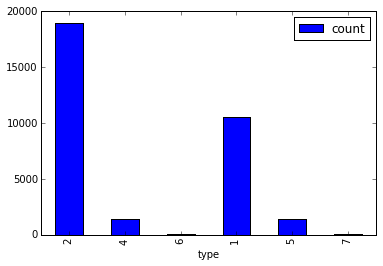

In [20]:
# However, in real life, data is never what you think it is
pandas_frame = pd.DataFrame(hist_data, columns=['type', 'count'])
pandas_frame.plot(kind='bar', x='type', y='count')

## What is the distribution of the number of comments per post?

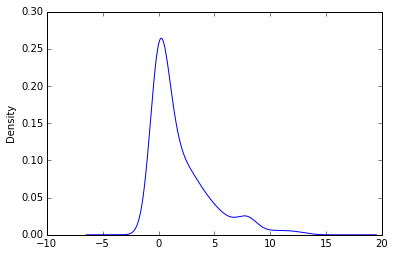

In [24]:
comment_counts = (
    rdd
    .map(lambda r: r.commentCount)
    .sample(False, 0.01, 0)
    .collect()
)

comment_counts_frame = pd.DataFrame(comment_counts, columns=['comment_count'])
comment_counts_frame.comment_count.plot(kind='kde')

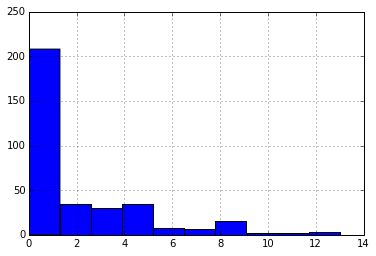

In [22]:
comment_counts_frame.answer_count.hist()